# Session 2.2 Pre-Class Work #

## Set-up libraries ##

In [25]:
import heapq
import random as rand
import scipy.stats as sts
import numpy as np 
import matplotlib.pyplot as plt 

## Simulation Code ##

In [9]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [10]:
# M/D/1 queue
class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class GroceryStore:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    grocery_store = GroceryStore(arrival_rate, service_rate)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return grocery_store

In [22]:
# Run a short test

grocery_store = run_simulation(arrival_rate=1.2, service_rate=1, run_until=100)
print(f'There are {grocery_store.queue.people_in_queue} people in the queue')

There are 23 people in the queue


## Simulations ## 

In [55]:
## 100 Simulations ###

sims = 100

# Parameters 
a_rate = 0.8
s_rate = 1

queue_count = []
for i in range(sims):
    grocery_store = run_simulation(arrival_rate = a_rate, service_rate =s_rate, run_until = 100)
    queue_count.append(grocery_store.queue.people_in_queue)
    


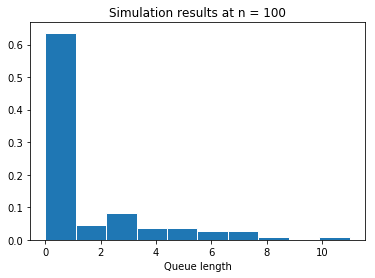

Average Queue Length: 1.48
St. dev.: 2.243
Median: 0.0
95% Confidence Interval of true mean: [1.038, 1.922]


In [73]:
plt.hist(queue_count, density = True, edgecolor = 'white')
plt.title('Simulation results at n = 100')
plt.xlabel('Queue length')
plt.show()

print("Average Queue Length:",np.mean(queue_count))
print("St. dev.:", np.round(np.std(queue_count),3))
print("Median:", np.median(queue_count))

# Calculate confidence interval 
def conf_int(data):
    m = np.mean(data)
    t = sts.sem(data)
    return [np.round(m - 1.96*t,3), np.round(m + 1.96*t,3)]

print("95% Confidence Interval of true mean:", conf_int(queue_count))


In [74]:
### 1000 Simulations ###

sims = 1000

queue_count_2 = []
for i in range(sims):
    grocery_store = run_simulation(arrival_rate = a_rate, service_rate =s_rate, run_until = 100)
    queue_count_2.append(grocery_store.queue.people_in_queue)
    

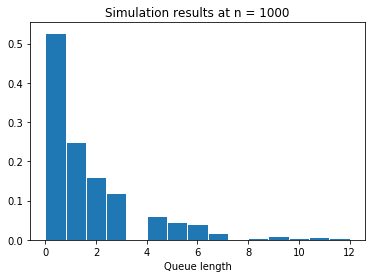

Average Queue Length: 1.654
St. dev.: 2.199
Median: 1.0
95% Confidence Interval of true mean: [1.518, 1.79]


In [121]:
plt.hist(queue_count_2, density = True, edgecolor = 'white', bins = 15)
plt.title('Simulation results at n = 1000')
plt.xlabel('Queue length')
plt.show()

print("Average Queue Length:",np.mean(queue_count_2))
print("St. dev.:", np.round(np.std(queue_count_2),3))
print("Median:", np.median(queue_count_2))
print("95% Confidence Interval of true mean:", conf_int(queue_count_2))


## Comparison between Graphs ##

There are multiple differences that we can notice between the difference in sample sizes. With n = 100, we see a sharper exponential decline compared to a smoother decrease with n = 1000. We can also see a bigger range for the confidence interval for smaller sample and a smaller range of the confidence interval for the bigger sample (n = 1000). Therefore, we can say that as we increase our simulations, we can have more stable results. By stable, I mean to have results that have smoother curves and smaller confidence interval. However, these intuitions are only limited to these two experiments and may change as we conduct more. 

## Simulations with Varying Arrival Rates ##

Note. The confidence intervals may seem similar because the range of the x-values are also expanding. 

In [104]:
# Create a function to create plots and compute mean and confidence interval 

def queue_modeling(a_rate, s_rate, simulations):

    # Acquire data
    queue_count = []
    for i in range(simulations):
        grocery_store = run_simulation(arrival_rate = a_rate, service_rate =s_rate, run_until = 100)
        queue_count.append(grocery_store.queue.people_in_queue)
        
    
    # Compute statistics 
    m = np.mean(queue_count)
    std = np.std(queue_count)
    conf = conf_int(queue_count)
        
    plt.hist(queue_count, density = True, edgecolor = 'white', bins = 15)
    plt.title('Simulation results at n = 1000')
    plt.axvline(conf[0], color = 'red', linestyle = '--', label = 'Confidence Interval')
    plt.axvline(conf[1], color = 'red', linestyle = '--')
    plt.xlabel('Queue length')
    plt.legend()
    plt.show()

    print("Number of simulations", len(queue_count))
    print("Average Queue Length:",m)
    print("St. dev.:", np.round(std, 3))
    print("95% Confidence Interval of true mean:", conf)


#### When arrival rate = 0.6 ####

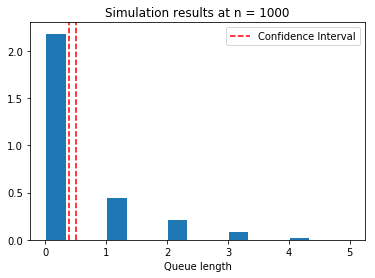

Number of simulations 1000
Average Queue Length: 0.447
St. dev.: 0.87
95% Confidence Interval of true mean: [0.393, 0.501]


In [117]:
queue_modeling(0.6, 1, 1000)

#### When arrival rate = 0.7 ####

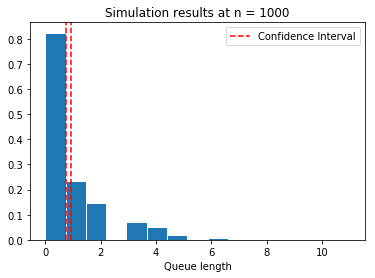

Number of simulations 1000
Average Queue Length: 0.854
St. dev.: 1.429
95% Confidence Interval of true mean: [0.765, 0.943]


In [118]:
queue_modeling(0.7, 1, 1000)

#### When arrival rate = 0.8 ### 

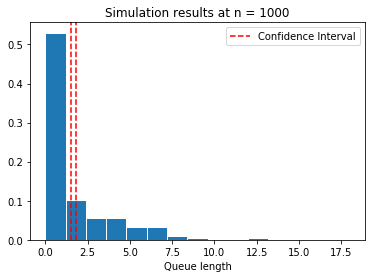

Number of simulations 1000
Average Queue Length: 1.662
St. dev.: 2.344
95% Confidence Interval of true mean: [1.517, 1.807]


In [106]:
queue_modeling(0.8, 1, 1000)

#### When arrival rate = 0.9 ### 

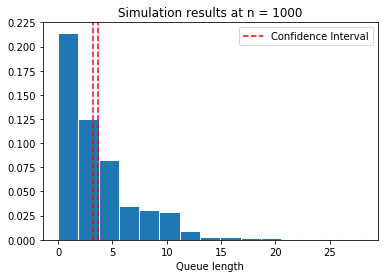

Number of simulations 1000
Average Queue Length: 3.414
St. dev.: 3.815
95% Confidence Interval of true mean: [3.177, 3.651]


In [107]:
queue_modeling(0.9, 1, 1000)

#### When arrival rate = 1 ### 

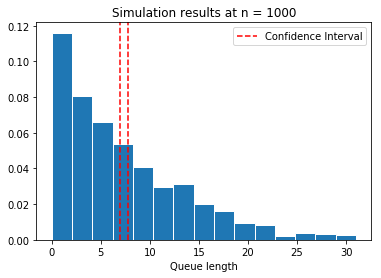

Number of simulations 1000
Average Queue Length: 7.363
St. dev.: 6.227
95% Confidence Interval of true mean: [6.977, 7.749]


In [112]:
queue_modeling(1, 1, 1000)

### Plotting Error Bar ### 

For this part, we acquire the average mean of the different experiments of varying arrival length. We also acquire the standard deviation of each part and used it as our range for our error plot. We did not experiment with arrival rates higher than service rate because it is impractical to have arrival rates higher than our service rate. 

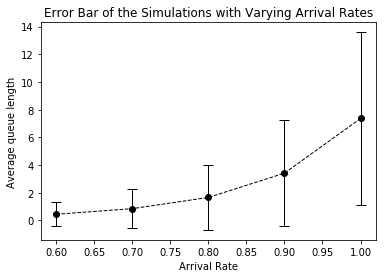

In [123]:
# Create function to acquire standard error 

queue_arrival_rates = [0.6, 0.7, 0.8, 0.9, 1]
queue_length_ave = [0.447, 0.854, 1.662, 3.414, 7.363]
queue_length_std = [0.87, 1.429, 2.344, 3.815, 6.227]

plt.errorbar(queue_arrival_rates, queue_length_ave, queue_length_std,
            color = 'black', marker = 'o', capsize = 5, linestyle = '--', linewidth = 1)
plt.title("Error Bar of the Simulations with Varying Arrival Rates")
plt.xlabel("Arrival Rate")
plt.ylabel("Average queue length")
plt.show()


#### Analysis ####

In our new experiment, we notice that as our arrival rate gets closer to our service rate, the spread or standard deviation of the data increases. We can also see this in our confidence interval with increasing range. Based on our error plot, we also see the same trend of error spread as we increase the arrival rate. In our error plot, we can determine that the average queue length becomes bigger than 5 with arrival rates between 0.9 and 1. 

## Reflection ##  

**#EmpiricalAnalysis**: I was able to generate statistical results that are needed by the prompt. These are means, standard deviations, confidence intervals. I used proper python implementations for how to acquire these values. I also added justifications and applications of the statistical values in the graphs that were generated. Next, I also performed analysis and used the parameters acquired to support my claims.

**#Professionalism**: The format of the notebook was easy to follow. The graphs were cleanly generated with proper labels and captions. The choice of colors, adding of legeds, and style of graphs were also properly chosen to represent the figures to be easily understood. 